In [1]:
### IMPORTS ###
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter
import glob
import pickle
from datetime import datetime
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

First we want to define a function to compute the channel tuning

In [2]:
### FUNCTION TO COMPUTE CHANNEL TUNING ###

def compute_channel_tuning(data):
    # Check if data is a tuple and extract the dictionary if necessary
    if isinstance(data, tuple):
        if data[0] is None and isinstance(data[1], dict):
            data = data[1]
        elif isinstance(data[0], dict):
            data = data[0]
        else:
            print(f"Unexpected data structure: {type(data)}")
            return None

    # Extract relevant data
    finger_kinematics = data['finger_kinematics']
    sbp = data['sbp']
    
    channel_tuning = {}
    
    for i in range(sbp.shape[1]):  # Iterate over channels
        channel_data = sbp[:, i]
        
        # Check if channel_data or finger_kinematics are constant
        if np.all(channel_data == channel_data[0]) or np.all(finger_kinematics[:, 0] == finger_kinematics[0, 0]) or np.all(finger_kinematics[:, 1] == finger_kinematics[0, 1]):
            # If any are constant, set correlation to 0
            channel_tuning[f'sbp_channel_{i}'] = {
                'magnitude': 0,
                'angle': 0,
                'corr_index': 0,
                'corr_mrp': 0
            }
        else:
            # Compute correlation with index and mrp positions
            corr_index = stats.pearsonr(channel_data, finger_kinematics[:, 0])[0]
            corr_mrp = stats.pearsonr(channel_data, finger_kinematics[:, 1])[0]
            
            # Treat correlations as vector components
            magnitude = np.sqrt(corr_index**2 + corr_mrp**2)
            angle = np.degrees(np.arctan2(corr_mrp, corr_index))
            
            channel_tuning[f'sbp_channel_{i}'] = {
                'magnitude': magnitude,
                'angle': angle,
                'corr_index': corr_index,
                'corr_mrp': corr_mrp
            }
    
    return channel_tuning

Now we need to load our datasets in

In [ ]:
### LOAD AND PREPROCESS DATA ###

# Approximate total number of datasets
total_datasets = 405

# Create a progress bar
pbar = tqdm(total=total_datasets, desc="Processing datasets")

# Path to the folder containing pkl files (FIND THIS IN HISHAMS STUDENT FOLDER -> BIG DATASET -> AUTOTRIMMING AND PREPROCESSING)
data_folder = './preprocessing_092024'

# Get list of pkl files
pkl_files = sorted(glob.glob(os.path.join(data_folder, '*.pkl')))

# Dictionary to store results
results = {}

# Process each pkl file
counter = 405
for file in pkl_files:
    # Extract date from filename (assuming format like 'YYYY-MM-DD_data.pkl')
    date = pd.to_datetime(os.path.basename(file).split('_')[0])

    # Load data
    with open(file, 'rb') as f:
        data = pickle.load(f)
        
    # Compute channel tuning
    try:
        channel_tuning = compute_channel_tuning(data)
        if channel_tuning is not None:
            results[date] = channel_tuning
    except Exception as e:
        print(f"Error processing file {file}: {str(e)}")
        continue

    # Update the progress bar
    pbar.update(1)
    
    # Store results
    results[date] = channel_tuning

    counter += 1
    if counter == 405:
        break

# Close the progress bar
pbar.close()

Processing datasets: 414it [29:14,  4.24s/it]                         


Now we have our data in the results array. So lets organize it prepare it for visualization

In [4]:
### PREPARE DATA FOR VISUALIZATION ###
def prepare_tuning_data(results):
    # Create lists to store data
    dates = []
    channels = []
    magnitudes = []
    angles = []
    sbps = []

    for date, channel_data in results.items():
        for channel, metrics in channel_data.items():
            if 'mean_sbp' in metrics:
                dates.append(date)
                channels.append(channel)
                magnitudes.append(metrics['magnitude'])
                angles.append(metrics['angle'])
                sbps.append(metrics['mean_sbp'])
            else:
                dates.append(date)
                channels.append(channel)
                magnitudes.append(metrics['magnitude'])
                angles.append(metrics['angle'])
                sbps.append(0)

    
    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'channel': channels,
        'magnitude': magnitudes,
        'angle': angles,
        'mean_sbps': sbps
    })
    
    return df.pivot(index='date', columns='channel')

# Convert results to organized DataFrame
df_tuning = prepare_tuning_data(results)
df_tuning = df_tuning[:407]

Now lets do some visualizations

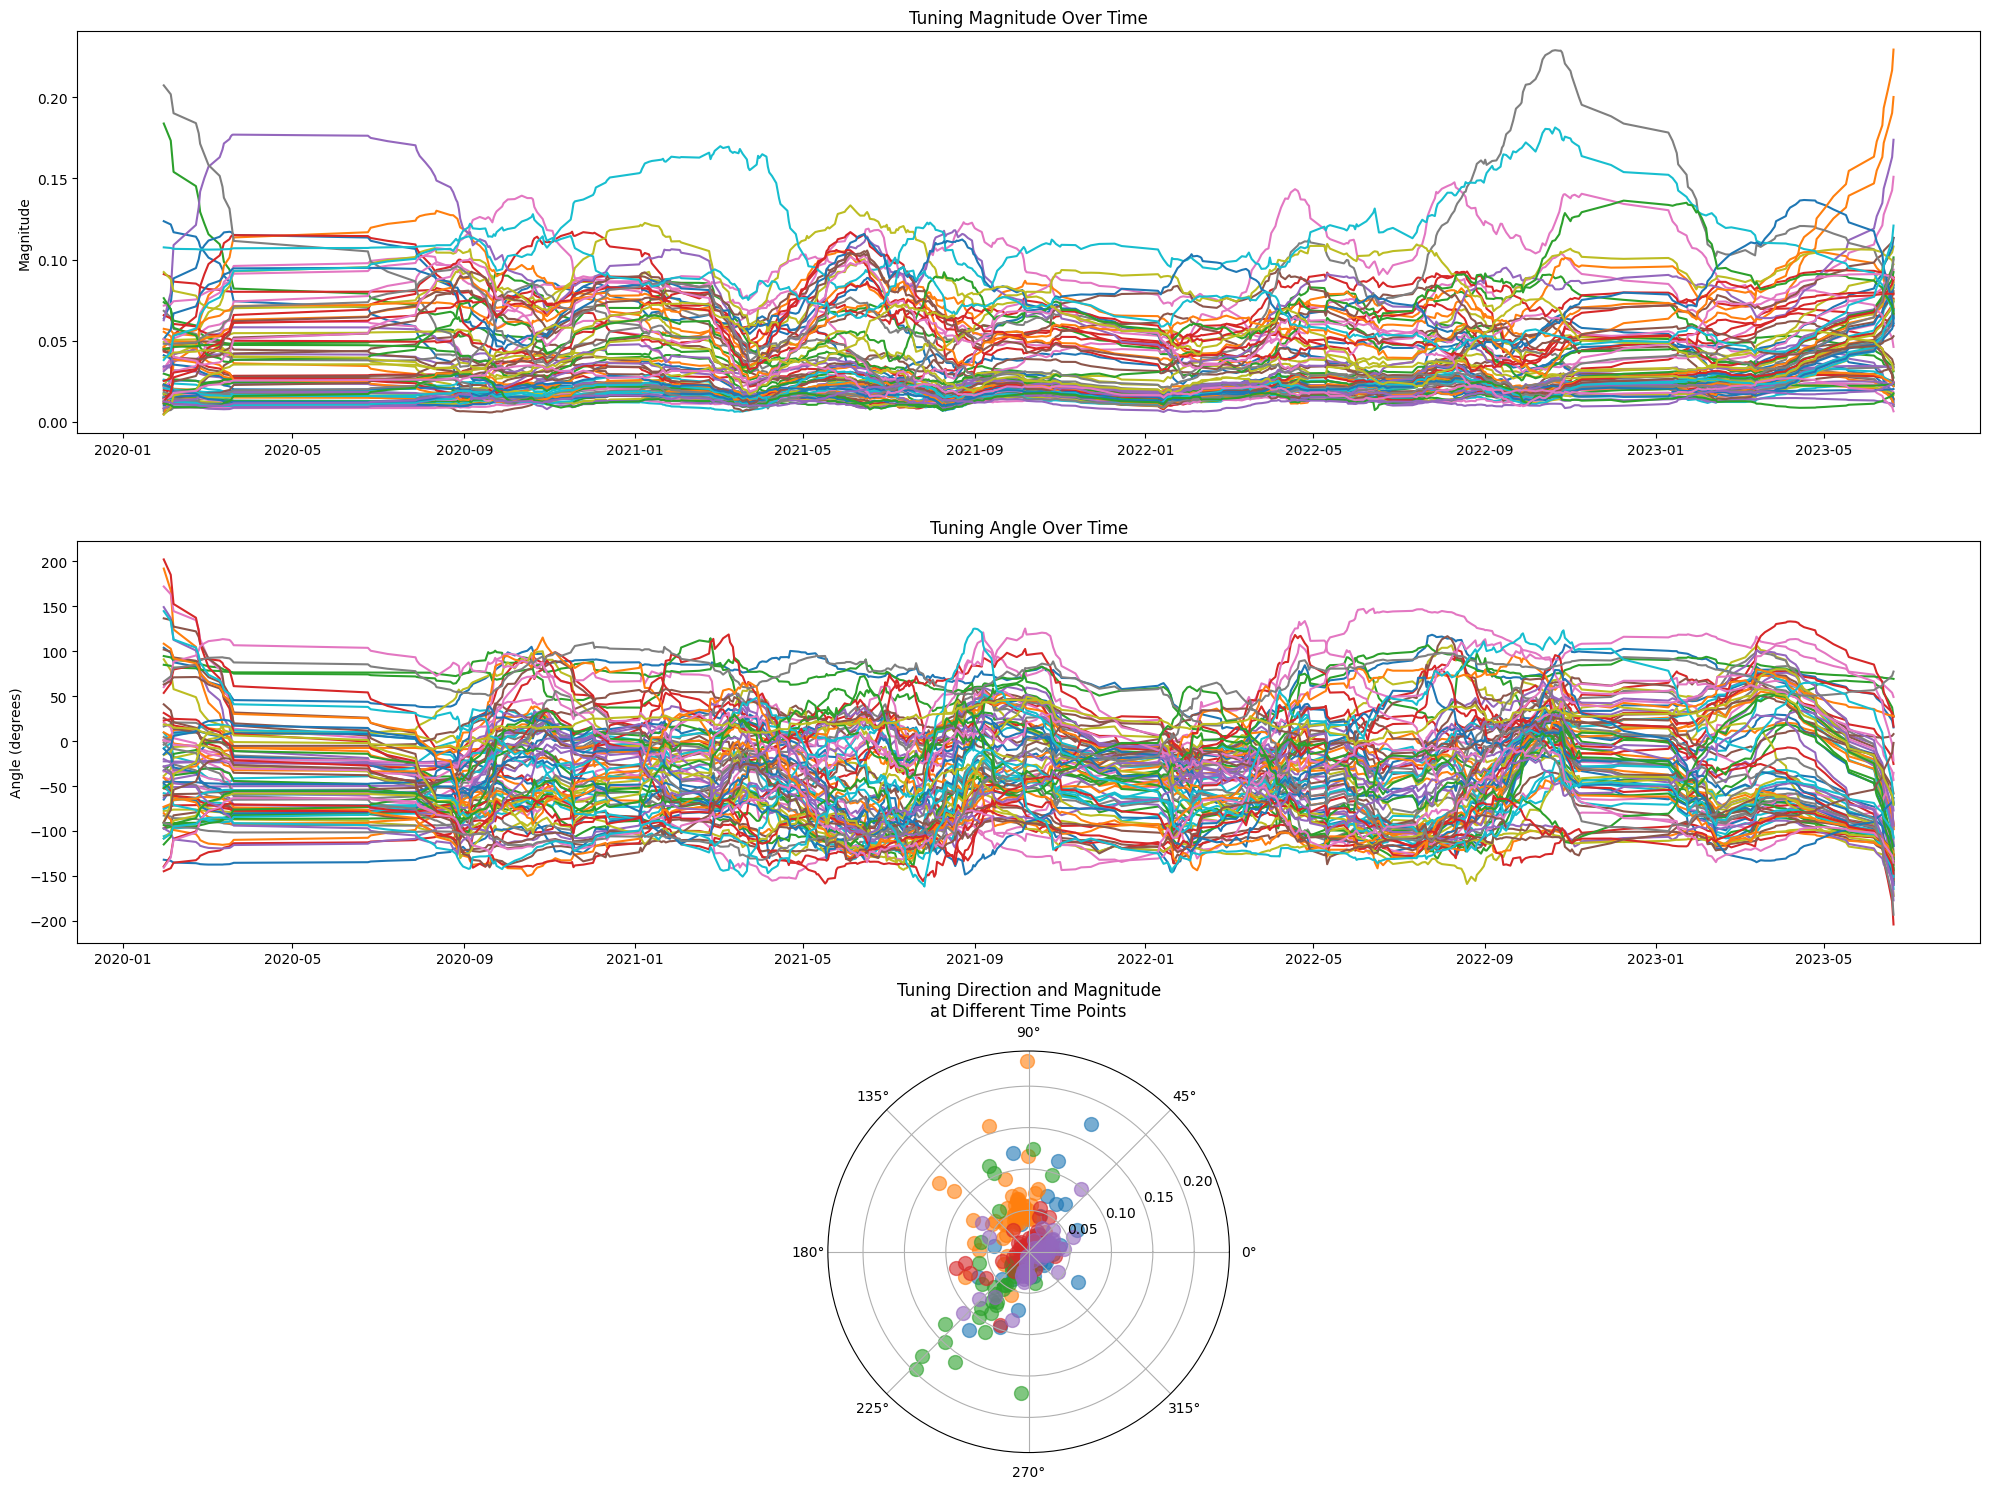

In [5]:
### VISUALIZATION ###
def plot_tuning_analysis(df_tuning, window_length=49, poly_order=3):
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Magnitude Plot
    ax1 = plt.subplot(311)
    for channel in df_tuning['magnitude'].columns[:80]:  # First 5 channels
        y = df_tuning['magnitude'][channel].values
        y_smooth = savgol_filter(y, window_length, poly_order)
        ax1.plot(df_tuning.index, y_smooth, label=channel)
    ax1.set_title('Tuning Magnitude Over Time')
    ax1.set_ylabel('Magnitude')
    # ax1.legend()
    
    # 2. Angle Plot
    ax2 = plt.subplot(312)
    for channel in df_tuning['angle'].columns[:80]:
        y = df_tuning['angle'][channel].values
        y_smooth = savgol_filter(y, window_length, poly_order)
        ax2.plot(df_tuning.index, y_smooth, label=channel)
    ax2.set_title('Tuning Angle Over Time')
    ax2.set_ylabel('Angle (degrees)')
    # ax2.legend()
    
    # 3. Polar Plot for Selected Time Points
    ax3 = plt.subplot(313, projection='polar')
    # Select a few time points to show evolution
    time_points = df_tuning.index[::len(df_tuning.index)//10][:5]  # 5 evenly spaced time points
    
    for idx, time_point in enumerate(time_points):
        angles = df_tuning['angle'].loc[time_point][:50].values  # First 5 channels
        magnitudes = df_tuning['magnitude'].loc[time_point][:50].values
        ax3.scatter(np.radians(angles), magnitudes, 
                   label=time_point.strftime('%Y-%m-%d'),
                   alpha=0.6, s=100)
    ax3.set_title('Tuning Direction and Magnitude\nat Different Time Points')
    # ax3.legend()
    
    plt.tight_layout()
    plt.show()

# Call the visualization functions
plot_tuning_analysis(df_tuning)


We have a animation below to visualize the tuning vector change for specified channels. It still needs some work to be polished.

In [96]:
# %matplotlib ipympl
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.animation import FuncAnimation
# import matplotlib.cm as cm



# def animate_tuning_with_history(df_tuning, history_window=10):
#     # Data preparation
#     time_points = df_tuning.index
#     angles = np.radians(df_tuning['angle'].iloc[:, 7].values)  # Convert to radians
#     magnitudes = df_tuning['magnitude'].iloc[:, 7].values
#     num_frames = len(time_points)

#     # Normalize magnitudes to fit on the plot
#     max_magnitude = magnitudes.max()
#     magnitudes = magnitudes / max_magnitude

#     # Setup the polar plot
#     fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
#     ax.set_title('Tuning Direction and Magnitude Over Time', va='bottom')
#     cmap = cm.get_cmap('viridis', num_frames)

#     # Store history of vectors for fading effect
#     history = []

#     def update(frame):
#         ax.clear()  # Clear the previous frame

#         # Current vector
#         angle = angles[frame]
#         magnitude = magnitudes[frame]
#         color = cmap(frame / num_frames)

#         # Add current vector to history
#         history.append((angle, magnitude, color))

#         # Plot all vectors in history with fading effect
#         for i, (h_angle, h_magnitude, h_color) in enumerate(history[-history_window:]):
#             alpha = (i + 1) / history_window  # Fade out older vectors
#             ax.quiver(0, 0, h_magnitude * np.cos(h_angle), h_magnitude * np.sin(h_angle),
#                       angles='xy', scale_units='xy', scale=1, color=h_color, alpha=alpha)

#         # Update title
#         ax.set_title(f'Time: {time_points[frame].strftime("%Y-%m-%d")}', va='bottom')

#         # Set the plot to center on 0 magnitude
#         ax.set_ylim(0, 1)

#     # Create the animation
#     ani = FuncAnimation(fig, update, frames=num_frames, interval=100, repeat=True)

#     # Display the animation
#     plt.show()

#     return ani

# # Call the function with your dataframe

# angles = np.radians(df_tuning['angle'].iloc[:, 7].values) # Convert to radians
# magnitudes = df_tuning['magnitude'].iloc[:, 7].values

# for i in range(len(angles)):
#     angle = angles[i]
#     magnitude = magnitudes[i]
#     print(f"{angle:.2f}°", magnitude)

# ani = animate_tuning_with_history(df_tuning)

Now we will look at individual parts of the tuning. We will first look at the magnitude. To understand differences in distribution across the years, we will calculate the JS Divergence and look at the KS statistics. To understand differences in means, we will do a t-test

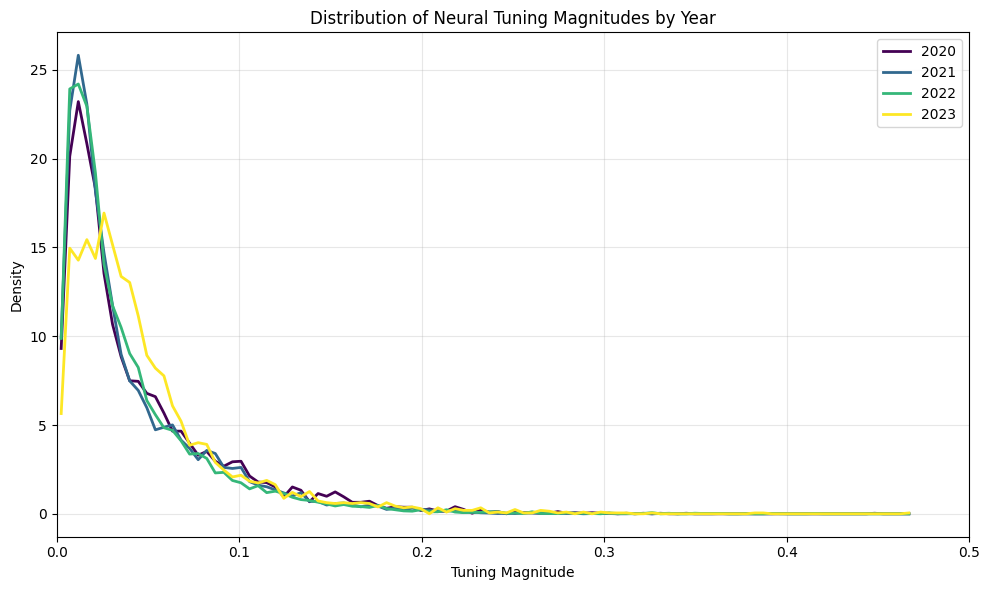

In [6]:
def plot_magnitude_distribution_outline(df_tuning):
    # Collect magnitudes and years
    magnitudes = []
    years = []
    
    for channel in df_tuning['magnitude'].columns:
        channel_magnitudes = df_tuning['magnitude'][channel]
        
        for date, mag in channel_magnitudes.items():
            if not np.isnan(mag):
                magnitudes.append(mag)
                years.append(date.year)
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create outline for each year
    unique_years = sorted(set(years))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))
    
    # Create bins for histogram
    range_min = 0
    range_max = max(magnitudes) if magnitudes else 0.1
    bin_width = (range_max - range_min) / 100  # Adjust for desired resolution
    bins = np.arange(range_min, range_max + bin_width, bin_width)

    for year, color in zip(unique_years, colors):
        year_magnitudes = [m for m, y in zip(magnitudes, years) if y == year]
        
        # Get histogram values for outline
        hist_values, _ = np.histogram(year_magnitudes, bins=bins, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Plot outline
        plt.plot(bin_centers, hist_values, color=color, linewidth=2, label=str(year))
    
    plt.xlabel('Tuning Magnitude')
    plt.ylabel('Density')
    plt.title('Distribution of Neural Tuning Magnitudes by Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set x-axis limits based on your magnitude ranges
    plt.xlim(0, 0.5)  # Adjust based on your data
    
    plt.tight_layout()
    plt.show()
    
plot_magnitude_distribution_outline(df_tuning)

In [7]:
from scipy.spatial.distance import jensenshannon
def analyze_distributions_with_means(df_tuning):
    # Collect magnitudes and years
    magnitudes = []
    years = []
    for channel in df_tuning['magnitude'].columns:
        channel_magnitudes = df_tuning['magnitude'][channel]
        for date, mag in channel_magnitudes.items():
            if not np.isnan(mag):
                magnitudes.append(mag)
                years.append(date.year)
    
    # Prepare distributions
    unique_years = sorted(set(years))
    bins = np.linspace(0, 0.5, 100)
    distributions = {}
    means = {}
    
    for year in unique_years:
        year_magnitudes = [m for m, y in zip(magnitudes, years) if y == year]
        hist, _ = np.histogram(year_magnitudes, bins=bins, density=True)
        distributions[year] = hist / hist.sum()
        means[year] = np.mean(year_magnitudes)
    
    # Calculate all statistics
    comparisons = {}
    for i, year1 in enumerate(unique_years):
        for year2 in unique_years[i+1:]:
            year_mags1 = [m for m, y in zip(magnitudes, years) if y == year1]
            year_mags2 = [m for m, y in zip(magnitudes, years) if y == year2]
            
            # Original tests
            js_div = jensenshannon(distributions[year1], distributions[year2])
            ks_stat, ks_pvalue = stats.ks_2samp(year_mags1, year_mags2)
            
            # Add t-test
            t_stat, t_pvalue = stats.ttest_ind(year_mags1, year_mags2, equal_var=False)
            
            comparisons[f"{year1}-{year2}"] = {
                "JS_divergence": js_div,
                "KS_statistic": ks_stat,
                "KS_p_value": ks_pvalue,
                "t_statistic": t_stat,
                "t_p_value": t_pvalue,
                "mean_diff": means[year2] - means[year1]
            }
    
    return comparisons, means

def print_extended_comparisons(comparisons, means):
    print("\n## Yearly Means ##")
    for year, mean in means.items():
        print(f"Year {year}: {mean:.4f}")
        
    print("\n## Distribution Comparisons Between Years ##")
    print(f"{'Years':12} {'JS Div':10} {'KS Stat':10} {'KS p-val':10} {'t-stat':10} {'t p-val':10} {'Mean Diff':10}")
    print("-" * 72)
    
    for years, stats in comparisons.items():
        print(f"{years:12} "
              f"{stats['JS_divergence']:.4f}    "
              f"{stats['KS_statistic']:.4f}    "
              f"{stats['KS_p_value']:.2e}  "
              f"{stats['t_statistic']:.4f}    "
              f"{stats['t_p_value']:.2e}  "
              f"{stats['mean_diff']:.4f}")

# Usage
comparisons, means = analyze_distributions_with_means(df_tuning)
print_extended_comparisons(comparisons, means)



## Yearly Means ##
Year 2020: 0.0456
Year 2021: 0.0408
Year 2022: 0.0394
Year 2023: 0.0487

## Distribution Comparisons Between Years ##
Years        JS Div     KS Stat    KS p-val   t-stat     t p-val    Mean Diff 
------------------------------------------------------------------------
2020-2021    0.0586    0.0519    1.96e-11  7.4748    8.26e-14  -0.0048
2020-2022    0.0741    0.0660    1.52e-17  9.4522    3.89e-21  -0.0061
2020-2023    0.1241    0.1286    2.94e-39  -3.6037    3.15e-04  0.0031
2021-2022    0.0480    0.0257    2.06e-04  2.7736    5.55e-03  -0.0014
2021-2023    0.1403    0.1679    4.05e-84  -10.5325    9.66e-26  0.0079
2022-2023    0.1326    0.1681    5.29e-82  -12.2087    6.17e-34  0.0093


We also want to know how the magnitude is changing over time, so lets look at a distribution of the time-weighted derivative of that metric, and do the same analyses we did previously

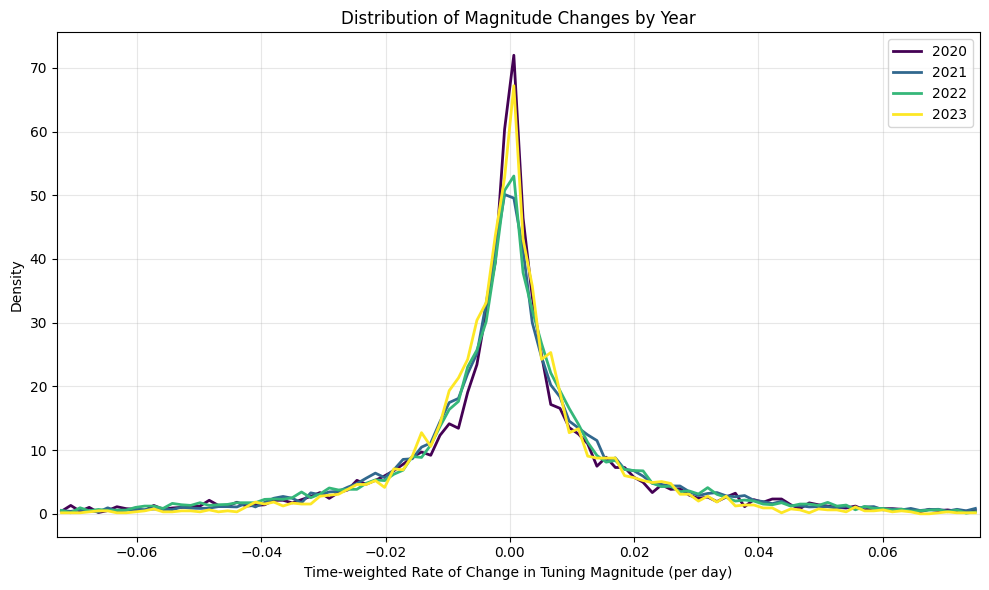

In [8]:
def plot_magnitude_distribution_outline_rolling(df_tuning):
    # Convert the nested dictionary structure to a DataFrame
    magnitudes_by_channel = {}
    
    for channel in df_tuning['magnitude'].columns:
        channel_magnitudes = df_tuning['magnitude'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)
    
    # Sort by date
    df_magnitudes.sort_index(inplace=True)
    
    # Compute time differences in days
    time_diff = df_magnitudes.index.to_series().diff().dt.total_seconds() / (24 * 3600)
    
    # Compute time-weighted derivatives
    derivatives = df_magnitudes.diff() / time_diff.values[:, np.newaxis]
    
    # Compute rolling average of derivatives (we are just doing 1-day here so no effect)
    window_size = '1D'
    rolling_avg = derivatives.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create outline for each year
    unique_years = sorted(set(df_magnitudes.index.year))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))
    
    # Create bins for histogram
    all_rates = rolling_avg.values.flatten()
    all_rates = all_rates[~np.isnan(all_rates)]
    
    range_min = np.percentile(all_rates, 1)  # 1st percentile to remove outliers
    range_max = np.percentile(all_rates, 99)  # 99th percentile to remove outliers
    bin_width = (range_max - range_min) / 100  # Adjust for desired resolution
    bins = np.arange(range_min, range_max + bin_width, bin_width)

    for year, color in zip(unique_years, colors):
        # Get rates for this year
        year_mask = rolling_avg.index.year == year
        year_rates = rolling_avg[year_mask].values.flatten()
        year_rates = year_rates[~np.isnan(year_rates)]
        
        if len(year_rates) > 0:
            # Get histogram values for outline
            hist_values, _ = np.histogram(year_rates, bins=bins, density=True)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            # Plot outline
            plt.plot(bin_centers, hist_values, color=color, linewidth=2, label=str(year))
    
    plt.xlabel('Time-weighted Rate of Change in Tuning Magnitude (per day)')
    plt.ylabel('Density')
    plt.title('Distribution of Magnitude Changes by Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set reasonable x-axis limits based on the data distribution
    plt.xlim(range_min, range_max)
    
    plt.tight_layout()
    plt.show()


plot_magnitude_distribution_outline_rolling(df_tuning)

In [9]:
def analyze_time_weighted_distributions(df_tuning):
    # Convert to DataFrame
    magnitudes_by_channel = {}
    for channel in df_tuning['magnitude'].columns:
        channel_magnitudes = df_tuning['magnitude'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)
    df_magnitudes.sort_index(inplace=True)
    
    # Calculate time-weighted derivatives
    time_diff = df_magnitudes.index.to_series().diff().dt.total_seconds() / (24 * 3600)
    derivatives = df_magnitudes.diff() / time_diff.values[:, np.newaxis]
    
    # Rolling average
    window_size = '1D'
    rolling_avg = derivatives.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Prepare distributions and means
    unique_years = sorted(set(rolling_avg.index.year))
    bins = np.linspace(-0.1, 0.1, 100)
    distributions = {}
    means = {}
    
    for year in unique_years:
        year_rates = rolling_avg[rolling_avg.index.year == year].values.flatten()
        year_rates = year_rates[~np.isnan(year_rates)]
        hist, _ = np.histogram(year_rates, bins=bins, density=True)
        distributions[year] = hist / hist.sum()
        means[year] = np.mean(year_rates)
    
    # Calculate statistics
    comparisons = {}
    for i, year1 in enumerate(unique_years):
        for year2 in unique_years[i+1:]:
            year_rates1 = rolling_avg[rolling_avg.index.year == year1].values.flatten()
            year_rates2 = rolling_avg[rolling_avg.index.year == year2].values.flatten()
            
            year_rates1 = year_rates1[~np.isnan(year_rates1)]
            year_rates2 = year_rates2[~np.isnan(year_rates2)]
            
            js_div = jensenshannon(distributions[year1], distributions[year2])
            t_stat, t_pvalue = stats.ttest_ind(year_rates1, year_rates2, equal_var=False)
            
            comparisons[f"{year1}-{year2}"] = {
                "JS_divergence": js_div,
                "t_statistic": t_stat,
                "t_p_value": t_pvalue,
                "mean_diff": means[year2] - means[year1]
            }
    
    return comparisons, means

def print_derivative_comparisons(comparisons, means):
    print("\n## Yearly Mean Rates of Change ##")
    for year, mean in means.items():
        print(f"Year {year}: {mean:.6f} per day")
    
    print("\n## Time-Weighted Rate Comparisons ##")
    print(f"{'Years':12} {'JS Div':10} {'t-stat':10} {'t p-val':10} {'Mean Diff':10}")
    print("-" * 60)
    
    for years, stats in comparisons.items():
        print(f"{years:12} "
              f"{stats['JS_divergence']:.4f}    "
              f"{stats['t_statistic']:.4f}    "
              f"{stats['t_p_value']:.2e}  "
              f"{stats['mean_diff']:.6f}")

# Usage
comparisons, means = analyze_time_weighted_distributions(df_tuning)
print_derivative_comparisons(comparisons, means)



## Yearly Mean Rates of Change ##
Year 2020: 0.000021 per day
Year 2021: 0.000458 per day
Year 2022: 0.000165 per day
Year 2023: 0.000158 per day

## Time-Weighted Rate Comparisons ##
Years        JS Div     t-stat     t p-val    Mean Diff 
------------------------------------------------------------
2020-2021    0.0742    -1.2128    2.25e-01  0.000437
2020-2022    0.0767    -0.3918    6.95e-01  0.000144
2020-2023    0.1049    -0.3429    7.32e-01  0.000137
2021-2022    0.0539    0.9834    3.25e-01  -0.000293
2021-2023    0.1026    0.8965    3.70e-01  -0.000301
2022-2023    0.1076    0.0217    9.83e-01  -0.000007


Now we would like to repeat the same analysis we did above except for Angles.

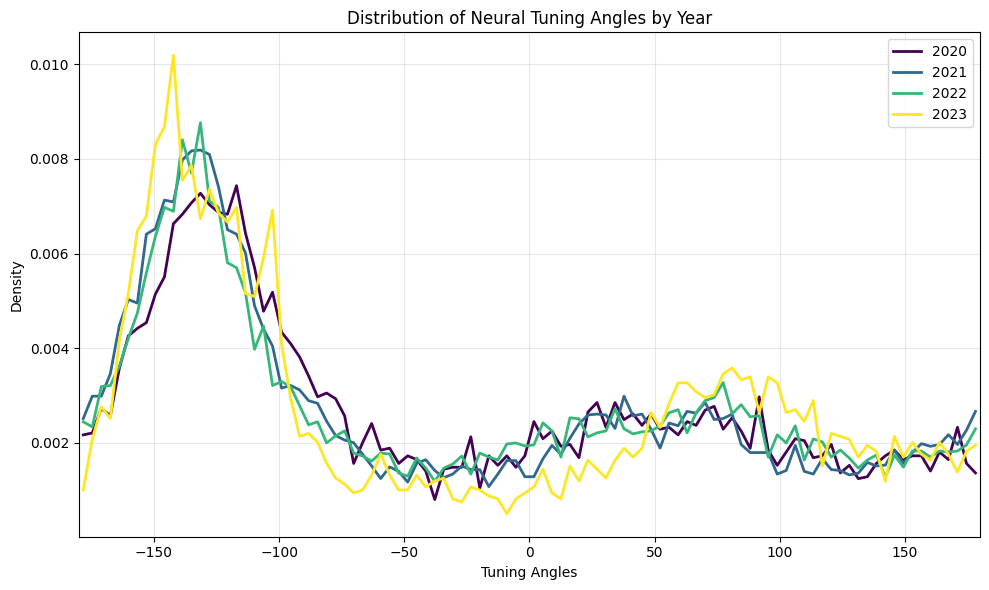

In [10]:
def plot_angle_distribution_outline(df_tuning):
    # Collect magnitudes and years
    magnitudes = []
    years = []
    
    for channel in df_tuning['angle'].columns:
        channel_magnitudes = df_tuning['angle'][channel]
        
        for date, mag in channel_magnitudes.items():
            if not np.isnan(mag):
                magnitudes.append(mag)
                years.append(date.year)
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create outline for each year
    unique_years = sorted(set(years))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))
    
    # Create bins for histogram
    range_min = -180
    range_max = 180 #max(magnitudes) if magnitudes else 0.1
    bin_width = (range_max - range_min) / 100  # Adjust for desired resolution
    bins = np.arange(range_min, range_max + bin_width, bin_width)

    for year, color in zip(unique_years, colors):
        year_magnitudes = [m for m, y in zip(magnitudes, years) if y == year]
        
        # Get histogram values for outline
        hist_values, _ = np.histogram(year_magnitudes, bins=bins, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Plot outline
        plt.plot(bin_centers, hist_values, color=color, linewidth=2, label=str(year))
    
    plt.xlabel('Tuning Angles')
    plt.ylabel('Density')
    plt.title('Distribution of Neural Tuning Angles by Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set x-axis limits based on your magnitude ranges
    plt.xlim(-180, 180)  # Adjust based on your data
    
    plt.tight_layout()
    plt.show()
    
plot_angle_distribution_outline(df_tuning)

In [11]:
def analyze_angle_distributions(df_tuning):
    # Collect angles and years
    angles = []
    years = []
    
    for channel in df_tuning['angle'].columns:
        channel_angles = df_tuning['angle'][channel]
        for date, ang in channel_angles.items():
            if not np.isnan(ang):
                angles.append(ang)
                years.append(date.year)
    
    # Prepare distributions
    unique_years = sorted(set(years))
    bins = np.linspace(-180, 180, 100)
    distributions = {}
    means = {}
    
    for year in unique_years:
        year_angles = [a for a, y in zip(angles, years) if y == year]
        hist, _ = np.histogram(year_angles, bins=bins, density=True)
        distributions[year] = hist / hist.sum()
        means[year] = np.mean(year_angles)
    
    # Calculate statistics
    comparisons = {}
    for i, year1 in enumerate(unique_years):
        for year2 in unique_years[i+1:]:
            year_angles1 = [a for a, y in zip(angles, years) if y == year1]
            year_angles2 = [a for a, y in zip(angles, years) if y == year2]
            
            # Calculate JS divergence
            js_div = jensenshannon(distributions[year1], distributions[year2])
            
            # Circular statistics might be more appropriate for angles,
            # but using t-test for consistency with previous analysis
            t_stat, t_pvalue = stats.ttest_ind(year_angles1, year_angles2, equal_var=False)
            
            comparisons[f"{year1}-{year2}"] = {
                "JS_divergence": js_div,
                "t_statistic": t_stat,
                "t_p_value": t_pvalue,
                "mean_diff": means[year2] - means[year1]
            }
    
    return comparisons, means

def print_angle_comparisons(comparisons, means):
    print("\n## Yearly Mean Angles ##")
    for year, mean in means.items():
        print(f"Year {year}: {mean:.2f} degrees")
    
    print("\n## Angular Distribution Comparisons ##")
    print(f"{'Years':12} {'JS Div':10} {'t-stat':10} {'t p-val':10} {'Mean Diff':10}")
    print("-" * 60)
    
    for years, stats in comparisons.items():
        print(f"{years:12} "
              f"{stats['JS_divergence']:.4f}    "
              f"{stats['t_statistic']:.4f}    "
              f"{stats['t_p_value']:.2e}  "
              f"{stats['mean_diff']:.2f}")

# Usage
comparisons, means = analyze_angle_distributions(df_tuning)
print_angle_comparisons(comparisons, means)



## Yearly Mean Angles ##
Year 2020: -38.38 degrees
Year 2021: -41.76 degrees
Year 2022: -35.74 degrees
Year 2023: -37.02 degrees

## Angular Distribution Comparisons ##
Years        JS Div     t-stat     t p-val    Mean Diff 
------------------------------------------------------------
2020-2021    0.0746    2.2125    2.69e-02  -3.37
2020-2022    0.0743    -1.7026    8.87e-02  2.65
2020-2023    0.1322    -0.6553    5.12e-01  1.36
2021-2022    0.0576    -4.6901    2.74e-06  6.02
2021-2023    0.1171    -2.5116    1.20e-02  4.74
2022-2023    0.1147    0.6724    5.01e-01  -1.28


Similarly, for angle rates of change...

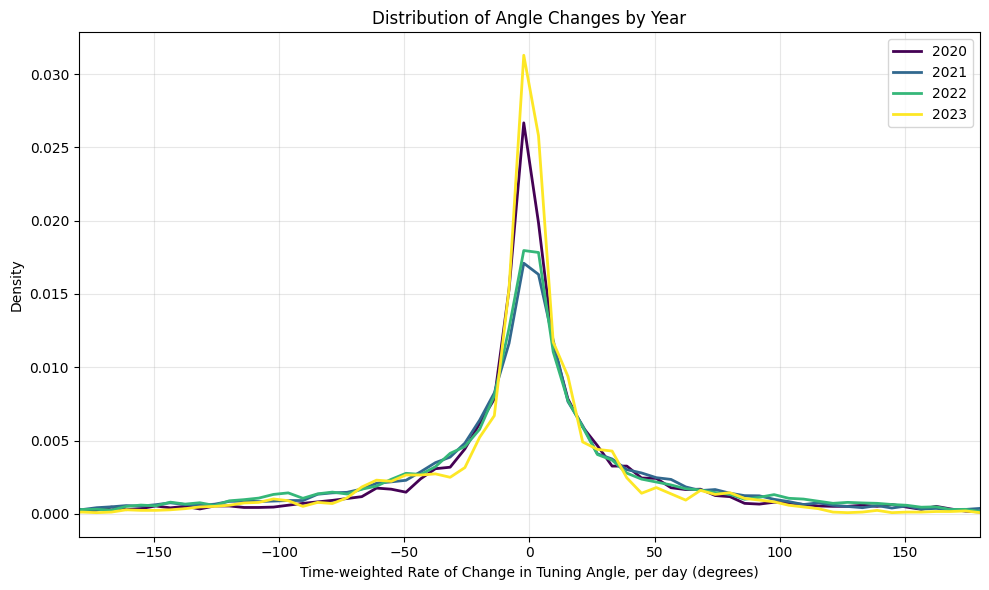

In [12]:
def plot_angle_distribution_outline_rolling(df_tuning):
    # Convert the nested dictionary structure to a DataFrame
    magnitudes_by_channel = {}
    
    for channel in df_tuning['angle'].columns:
        channel_magnitudes = df_tuning['angle'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes

    
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)
    # df_magnitudes = np.degrees(np.unwrap(np.radians(df_magnitudes)))


    
    # Sort by date
    df_magnitudes.sort_index(inplace=True)


    # Compute time differences in days
    time_diff = df_magnitudes.index.to_series().diff().dt.total_seconds() / (24 * 3600)

    # # Now do the unwrapping
    # df_magnitudes = pd.DataFrame(
    #     np.degrees(np.unwrap(np.radians(df_magnitudes.values))),
    #     index=df_magnitudes.index,
    #     columns=df_magnitudes.columns
    # )
    
    # Compute time-weighted derivatives
    derivatives = df_magnitudes.diff() / time_diff.values[:, np.newaxis]
    
    # Compute rolling average of derivatives (we are just doing 1-day here so no effect)
    window_size = '1D'
    rolling_avg = derivatives.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create outline for each year
    unique_years = sorted(set(df_magnitudes.index.year))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))
    
    # Create bins for histogram
    all_rates = rolling_avg.values.flatten()
    all_rates = all_rates[~np.isnan(all_rates)]
    
    range_min = np.percentile(all_rates, 1)  # 1st percentile to remove outliers
    range_max = np.percentile(all_rates, 99)  # 99th percentile to remove outliers
    bin_width = (range_max - range_min) / 100  # Adjust for desired resolution
    bins = np.arange(range_min, range_max + bin_width, bin_width)

    for year, color in zip(unique_years, colors):
        # Get rates for this year
        year_mask = rolling_avg.index.year == year
        year_rates = rolling_avg[year_mask].values.flatten()
        year_rates = year_rates[~np.isnan(year_rates)]
        
        if len(year_rates) > 0:
            # Get histogram values for outline
            hist_values, _ = np.histogram(year_rates, bins=bins, density=True)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            # Plot outline
            plt.plot(bin_centers, hist_values, color=color, linewidth=2, label=str(year))
    
    plt.xlabel('Time-weighted Rate of Change in Tuning Angle, per day (degrees)')
    plt.ylabel('Density')
    plt.title('Distribution of Angle Changes by Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set reasonable x-axis limits based on the data distribution
    plt.xlim(-180, 180)
    
    plt.tight_layout()
    plt.show()


plot_angle_distribution_outline_rolling(df_tuning)

In [14]:
def analyze_time_weighted_angle_distributions(df_tuning):
    # Convert to DataFrame
    magnitudes_by_channel = {}
    for channel in df_tuning['angle'].columns:
        channel_magnitudes = df_tuning['angle'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)
    df_magnitudes.sort_index(inplace=True)
    
    # Calculate time-weighted derivatives
    time_diff = df_magnitudes.index.to_series().diff().dt.total_seconds() / (24 * 3600)
    derivatives = df_magnitudes.diff() / time_diff.values[:, np.newaxis]
    
    # Rolling average
    window_size = '1D'
    rolling_avg = derivatives.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Prepare distributions and means
    unique_years = sorted(set(rolling_avg.index.year))
    bins = np.linspace(-180, 180, 100)
    distributions = {}
    means = {}
    
    for year in unique_years:
        year_rates = rolling_avg[rolling_avg.index.year == year].values.flatten()
        year_rates = year_rates[~np.isnan(year_rates)]
        hist, _ = np.histogram(year_rates, bins=bins, density=True)
        distributions[year] = hist / hist.sum()
        means[year] = np.mean(year_rates)
    
    # Calculate statistics
    comparisons = {}
    for i, year1 in enumerate(unique_years):
        for year2 in unique_years[i+1:]:
            year_rates1 = rolling_avg[rolling_avg.index.year == year1].values.flatten()
            year_rates2 = rolling_avg[rolling_avg.index.year == year2].values.flatten()
            
            year_rates1 = year_rates1[~np.isnan(year_rates1)]
            year_rates2 = year_rates2[~np.isnan(year_rates2)]
            
            js_div = jensenshannon(distributions[year1], distributions[year2])
            t_stat, t_pvalue = stats.ttest_ind(year_rates1, year_rates2, equal_var=False)
            
            comparisons[f"{year1}-{year2}"] = {
                "JS_divergence": js_div,
                "t_statistic": t_stat,
                "t_p_value": t_pvalue,
                "mean_diff": means[year2] - means[year1]
            }
    
    return comparisons, means

def print_angle_derivative_comparisons(comparisons, means):
    print("\n## Yearly Mean Rates of Change ##")
    for year, mean in means.items():
        print(f"Year {year}: {mean:.6f} per day")
    
    print("\n## Time-Weighted Rate Comparisons ##")
    print(f"{'Years':12} {'JS Div':10} {'t-stat':10} {'t p-val':10} {'Mean Diff':10}")
    print("-" * 60)
    
    for years, stats in comparisons.items():
        print(f"{years:12} "
              f"{stats['JS_divergence']:.4f}    "
              f"{stats['t_statistic']:.4f}    "
              f"{stats['t_p_value']:.2e}  "
              f"{stats['mean_diff']:.6f}")

# Usage
comparisons, means = analyze_time_weighted_angle_distributions(df_tuning)
print_angle_derivative_comparisons(comparisons, means)



## Yearly Mean Rates of Change ##
Year 2020: -0.518193 per day
Year 2021: -1.243589 per day
Year 2022: 0.930552 per day
Year 2023: 0.232268 per day

## Time-Weighted Rate Comparisons ##
Years        JS Div     t-stat     t p-val    Mean Diff 
------------------------------------------------------------
2020-2021    0.1036    0.5705    5.68e-01  -0.725396
2020-2022    0.1043    -1.1674    2.43e-01  1.448744
2020-2023    0.1090    -0.5499    5.82e-01  0.750460
2021-2022    0.0547    -1.9914    4.64e-02  2.174140
2021-2023    0.1479    -1.1993    2.30e-01  1.475856
2022-2023    0.1467    0.5823    5.60e-01  -0.698284


Now we see from the previous plots that year-to-year, the information encoded seems to be relatively stable. So why is the decoder unstable day-to-day then? Let's look at median day-to-day changes and median month-to-month changes to understand. We will be able to see a much tighter distribution of monthly changes compared to daily changes.

In [28]:
def calculate_angle_changes(df_tuning):
    angles_by_channel = {}
    for channel in df_tuning['angle'].columns:
        channel_angles = df_tuning['angle'][channel]
        angles_by_channel[channel] = channel_angles
    
    df_angles = pd.DataFrame(angles_by_channel)[:405]
    df_angles.sort_index(inplace=True)
    
    # Calculate changes for each channel
    daily_changes = df_angles.resample('D').mean().diff().abs()
    mean_daily_changes = daily_changes.median()
    
    monthly_changes = df_angles.resample('ME').mean().diff().abs()
    mean_monthly_changes = monthly_changes.median()
    
    
    return {
        'daily_mean': mean_daily_changes,
        'monthly_mean': mean_monthly_changes
    }


output_dict = calculate_angle_changes(df_tuning)

print("Mean of Mean Day-to-Day Changes: ", output_dict["daily_mean"].mean(), "Mean of Mean Month-to-Month Changes: ", output_dict["monthly_mean"].mean())



Mean of Mean Day-to-Day Changes:  46.00052176633303 Mean of Mean Month-to-Month Changes:  32.94291059846919


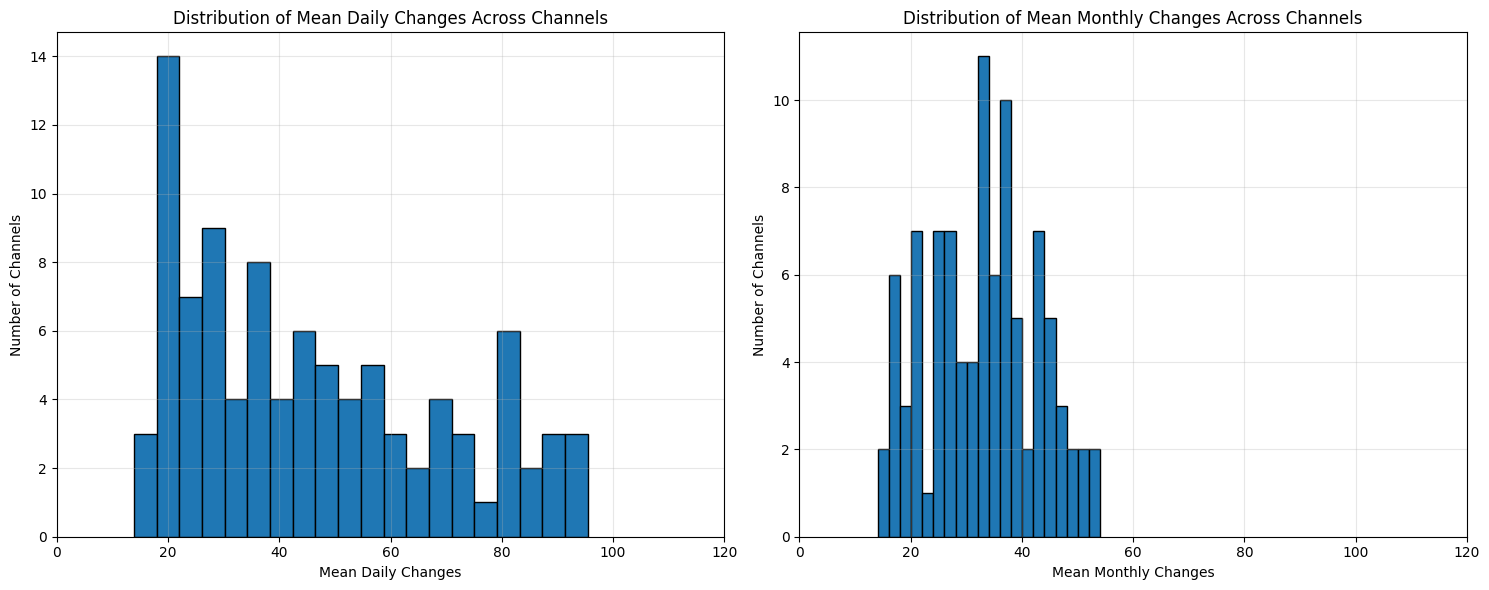


Daily Changes Summary:
Mean: 46.0005
Std: 23.1210
Min: 13.8414
Max: 95.4621

Monthly Changes Summary:
Mean: 32.9429
Std: 9.8411
Min: 14.0826
Max: 54.0562


In [30]:
def plot_change_distributions(df_tuning):
    # Calculate changes
    output_dict = calculate_angle_changes(df_tuning)
    daily_means = output_dict['daily_mean']
    monthly_means = output_dict['monthly_mean']
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Daily changes histogram
    ax1.hist(daily_means, bins=20, edgecolor='black')
    ax1.set_title('Distribution of Mean Daily Changes Across Channels')
    ax1.set_xlabel('Mean Daily Changes')
    ax1.set_ylabel('Number of Channels')
    ax1.set_xlim(0, 120)  # Set x-axis range
    ax1.grid(True, alpha=0.3)
    
    # Monthly changes histogram
    ax2.hist(monthly_means, bins=20, edgecolor='black')
    ax2.set_title('Distribution of Mean Monthly Changes Across Channels')
    ax2.set_xlabel('Mean Monthly Changes')
    ax2.set_ylabel('Number of Channels')
    ax2.set_xlim(0, 120)  # Set x-axis range
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nDaily Changes Summary:")
    print(f"Mean: {daily_means.mean():.4f}")
    print(f"Std: {daily_means.std():.4f}")
    print(f"Min: {daily_means.min():.4f}")
    print(f"Max: {daily_means.max():.4f}")
    
    print("\nMonthly Changes Summary:")
    print(f"Mean: {monthly_means.mean():.4f}")
    print(f"Std: {monthly_means.std():.4f}")
    print(f"Min: {monthly_means.min():.4f}")
    print(f"Max: {monthly_means.max():.4f}")

# Call the function
plot_change_distributions(df_tuning)


That is most of the analysis. For the future, some analysis can be done on the below graph, looking at if the decoder may be succesful across different states, even if the channels that make up the states change. 

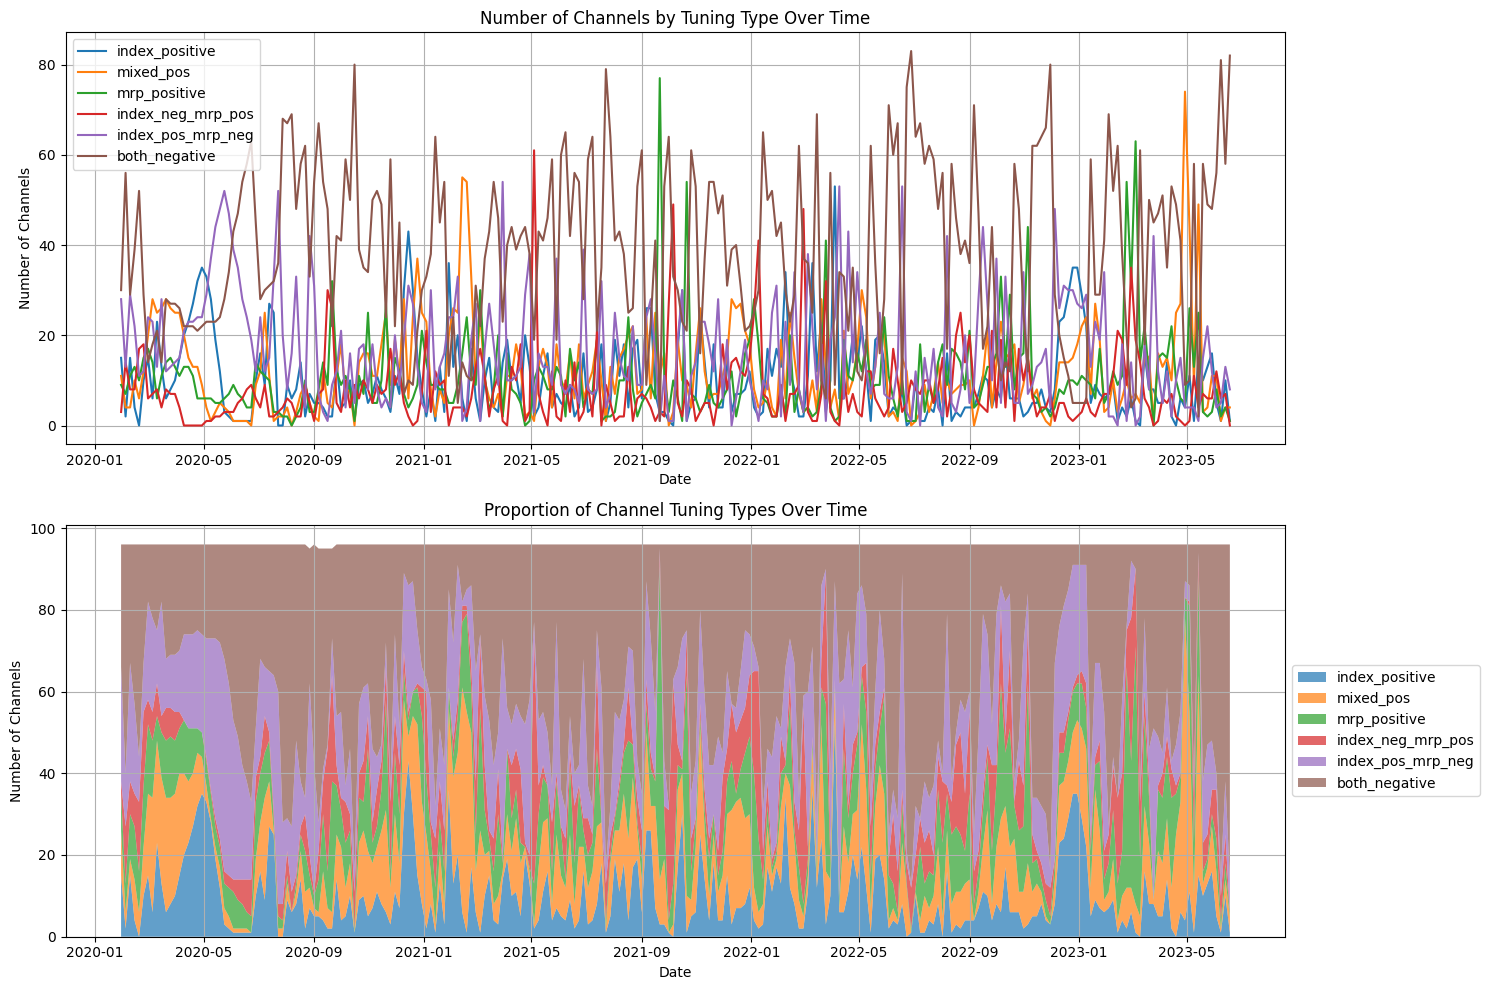


Average number of channels in each category:
index_positive: 10.1
mixed_pos: 12.2
mrp_positive: 10.6
index_neg_mrp_pos: 7.8
index_pos_mrp_neg: 16.7
both_negative: 38.6

Average Magnitudes:
Negative angles (-180° to -90°): 0.04
All other angles: 0.04


In [32]:
def analyze_tuning_characteristics(df_tuning):
    # Define angle boundaries for categories
    angle_categories = {
        'index_positive': (-22.5, 22.5),
        'mixed_pos': (22.5, 67.5),
        'mrp_positive': (67.5, 112.5),
        'index_neg_mrp_pos': (112.5, 180),
        'index_pos_mrp_neg': (-90, -22.5),
        'both_negative': (-180, -90)
    }

    df_tuning = df_tuning.resample('D').interpolate(method='linear')
    
    # Use vectorized operations instead of loops
    def categorize_angles(angles, magnitudes):
        counts = {k: 0 for k in angle_categories}
        mask = magnitudes > 0
        valid_angles = angles[mask]
        
        for category, (lower, upper) in angle_categories.items():
            counts[category] = np.sum((valid_angles >= lower) & (valid_angles <= upper))
        
        return counts
    
    # Process all channels at once for each timepoint
    tuning_counts = {category: [] for category in angle_categories}
    
    # Vectorized operation over timepoints
    for time in df_tuning.index[::5]:  # Sample every 5th timepoint
        angles = df_tuning['angle'].loc[time]
        magnitudes = df_tuning['magnitude'].loc[time]
        counts = categorize_angles(angles, magnitudes)
        
        for category in angle_categories:
            tuning_counts[category].append(counts[category])
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    timepoints = df_tuning.index[::5]  # Use same sampling as above
    
    # Time series plot
    for category, values in tuning_counts.items():
        ax1.plot(timepoints, values, label=category)
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Channels')
    ax1.set_title('Number of Channels by Tuning Type Over Time')
    ax1.legend()
    ax1.grid(True)
    
    # Stacked area plot
    data = np.array(list(tuning_counts.values()))
    ax2.stackplot(timepoints, data, 
                 labels=tuning_counts.keys(),
                 alpha=0.7)
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Number of Channels')
    ax2.set_title('Proportion of Channel Tuning Types Over Time')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nAverage number of channels in each category:")
    for category in tuning_counts:
        mean_count = np.mean(tuning_counts[category])
        print(f"{category}: {mean_count:.1f}")


    mask_negative = (df_tuning['angle'] >= -180) & (df_tuning['angle'] < -90)
    mask_positive = (df_tuning['angle'] >= 0) & (df_tuning['angle'] < 90)
    avg_magnitude_negative = df_tuning['magnitude'][mask_negative].mean().mean()
    
    mask_elsewhere = ~mask_negative
    avg_magnitude_elsewhere = df_tuning['magnitude'][mask_positive].mean().mean()
    
    print("\nAverage Magnitudes:")
    print(f"Negative angles (-180° to -90°): {avg_magnitude_negative:.2f}")
    print(f"All other angles: {avg_magnitude_elsewhere:.2f}")
    

analyze_tuning_characteristics(df_tuning)


Note: There are some other graphs on the rough copy of the doc that don't contain a lot of new/useful information, but if you are curious they can be found there. 

There are also methods to compute tuning vector with regression fits/calculations on the rough copy too, as well as comparisons to the SBP over time.